({'0':       upgrade in.ashrae_iecc_climate_zone_2004 in.geometry_building_type_recs  \
  0           0                               1A  Multi-Family with 2 - 4 Units   
  1           0                               1A  Multi-Family with 2 - 4 Units   
  2           0                               1A  Multi-Family with 2 - 4 Units   
  3           0                               1A  Multi-Family with 2 - 4 Units   
  4           0                               1A  Multi-Family with 2 - 4 Units   
  ...       ...                              ...                            ...   
  8755        0                               1A  Multi-Family with 2 - 4 Units   
  8756        0                               1A  Multi-Family with 2 - 4 Units   
  8757        0                               1A  Multi-Family with 2 - 4 Units   
  8758        0                               1A  Multi-Family with 2 - 4 Units   
  8759        0                               1A  Multi-Family with 2 - 4 Units   

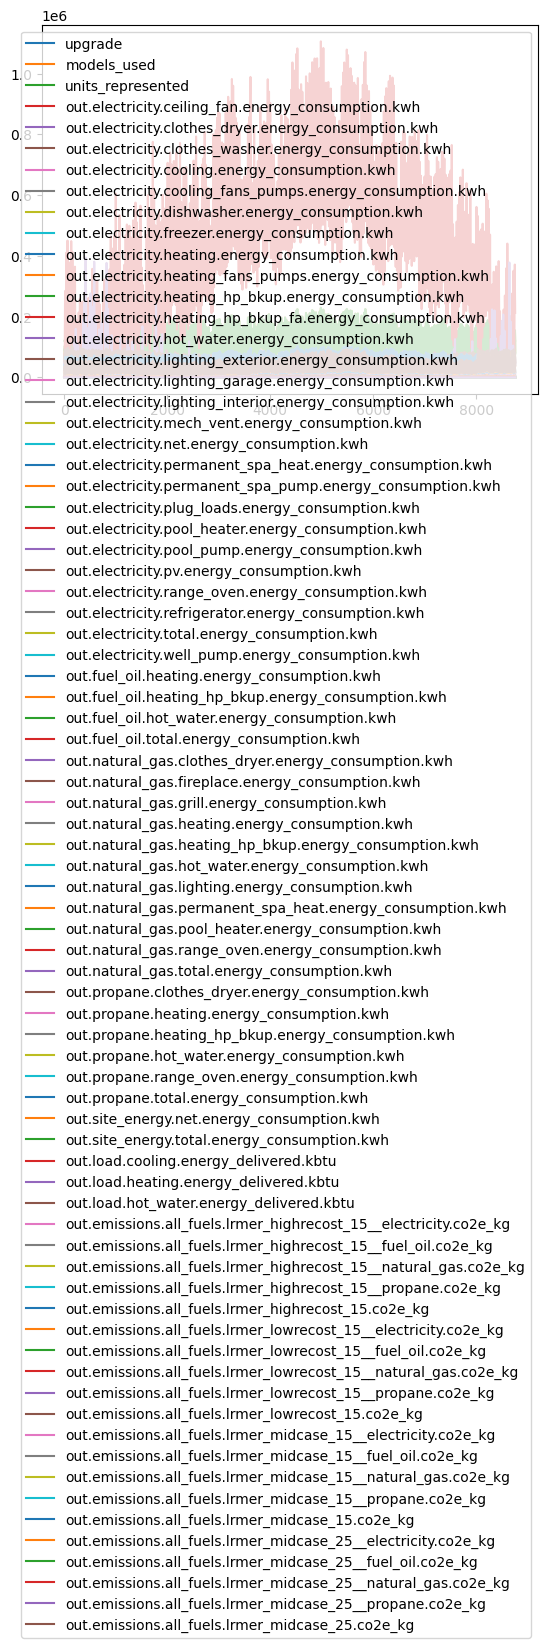

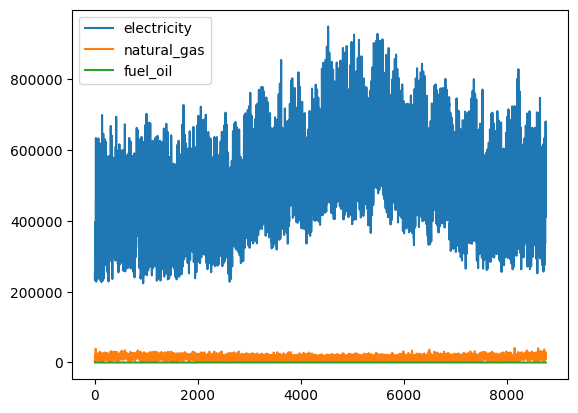

In [2]:

%matplotlib inline
import pyarrow as pa
import pandas as pd
import pyarrow.compute as pc
from pyarrow import csv
import numpy as np

from data_pipeline_homebrew.pandas import pandas_pipeline as pp
from importlib import reload
import io
import requests

reload(pp)



url:str = r"https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/resstock_tmy3_release_2/timeseries_aggregates/by_ashrae_iecc_climate_zone_2004/upgrade=0/ashrae_iecc_climate_zone_2004=1A/up00-1a-multi-family_with_2_-_4_units.csv"


csv_data = pp.LocalCSVDataSource(url)

def fuel_summation_schema_function(schema: pp.PandasSchema):
    return pp.PandasSchema(
        {
            'electricity': np.float64,
            'natural_gas': np.float64,
            'fuel_oil': np.float64,
        }
    )

def fuel_summation_function(data: pd.DataFrame):
    fuels = [
        'electricity',
        'natural_gas',
        'fuel_oil',
    ]
    fuel_columns = {
        fuel: [col for col in data.columns if fuel in col]
        for fuel in fuels
    }

    data_dict = {fuel: data[fuel_columns[fuel]].sum(axis=1)
        for fuel, cols in fuel_columns.items()
    }
    return pd.DataFrame(data_dict)

fuel_summation_transformer = pp.PandasTransformer(
    transform_function=fuel_summation_function,
    schema_function=fuel_summation_schema_function
)

builder = pp.PandasMatplotlibPipelineBuilder.empty()

builder.add_source(source=csv_data, stack_id="0")
builder.add_transformer(transformer=fuel_summation_transformer, target_stack_id="1", source_stack_id="0")
builder.add_artifact(stack_id="1", artifact_class=pp.SimpleLinePlot)
builder.add_artifact(stack_id="0", artifact_class=pp.SimpleLinePlot)

builder.generate(), builder.stacks






In [69]:
import pandas as pd
df = pd.read_csv(ResstockDataSource().url)
df

,upgrade,in.ashrae_iecc_climate_zone_2004,in.geometry_building_type_recs,timestamp,models_used,units_represented,out.electricity.ceiling_fan.energy_consumption.kwh,out.electricity.clothes_dryer.energy_consumption.kwh,out.electricity.clothes_washer.energy_consumption.kwh,out.electricity.cooling.energy_consumption.kwh,...,out.emissions.all_fuels.lrmer_midcase_15__electricity.co2e_kg,out.emissions.all_fuels.lrmer_midcase_15__fuel_oil.co2e_kg,out.emissions.all_fuels.lrmer_midcase_15__natural_gas.co2e_kg,out.emissions.all_fuels.lrmer_midcase_15__propane.co2e_kg,out.emissions.all_fuels.lrmer_midcase_15.co2e_kg,out.emissions.all_fuels.lrmer_midcase_25__electricity.co2e_kg,out.emissions.all_fuels.lrmer_midcase_25__fuel_oil.co2e_kg,out.emissions.all_fuels.lrmer_midcase_25__natural_gas.co2e_kg,out.emissions.all_fuels.lrmer_midcase_25__propane.co2e_kg,out.emissions.all_fuels.lrmer_midcase_25.co2e_kg
0,0,1A,Multi-Family with 2 - 4 Units,2018-01-01 01:00:00,477,120347.881674,1257.471367,1676.544389,126.403121,8181.385239,...,25598.025159,0.0,403.277932,0.0,26001.307669,25627.203317,0.0,403.277932,0.0,26030.484682
1,0,1A,Multi-Family with 2 - 4 Units,2018-01-01 02:00:00,477,120347.881674,1167.651984,2958.236714,45.666597,6823.497819,...,27236.578512,0.0,492.719010,0.0,27729.296377,27282.414861,0.0,492.719010,0.0,27775.131582
2,0,1A,Multi-Family with 2 - 4 Units,2018-01-01 03:00:00,477,120347.881674,1144.187932,724.105703,51.721836,6229.832064,...,24755.195727,0.0,368.946447,0.0,25124.142174,24815.331616,0.0,368.946447,0.0,25184.279208
3,0,1A,Multi-Family with 2 - 4 Units,2018-01-01 04:00:00,477,120347.881674,1135.861978,540.682412,8.325954,5489.831357,...,25102.931476,0.0,335.291315,0.0,25438.220502,25277.908866,0.0,335.291315,0.0,25613.200181
4,0,1A,Multi-Family with 2 - 4 Units,2018-01-01 05:00:00,477,120347.881674,1140.151105,836.379932,21.697941,4604.000304,...,25058.162871,0.0,434.192176,0.0,25492.359625,25861.175609,0.0,434.192176,0.0,26295.370074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0,1A,Multi-Family with 2 - 4 Units,2018-12-31 20:00:00,477,120347.881674,3031.656491,6614.339761,277.027199,25226.883952,...,57937.353671,0.0,1856.867677,0.0,59794.223636,68675.199401,0.0,1856.867677,0.0,70532.065933
8756,0,1A,Multi-Family with 2 - 4 Units,2018-12-31 21:00:00,477,120347.881674,3341.987507,4358.006206,234.135921,24115.242931,...,57280.338151,0.0,1637.043861,0.0,58917.377435,67143.284340,0.0,1637.043861,0.0,68780.323623
8757,0,1A,Multi-Family with 2 - 4 Units,2018-12-31 22:00:00,477,120347.881674,3049.822209,7653.570211,267.187435,22803.274410,...,54987.633765,0.0,1299.139833,0.0,56286.763298,63509.505102,0.0,1299.139833,0.0,64808.641502
8758,0,1A,Multi-Family with 2 - 4 Units,2018-12-31 23:00:00,477,120347.881674,2087.291457,3928.841118,67.616839,21641.929967,...,52607.306786,0.0,1127.187147,0.0,53734.491645,56943.449224,0.0,1127.187147,0.0,58070.632938


<Axes: >

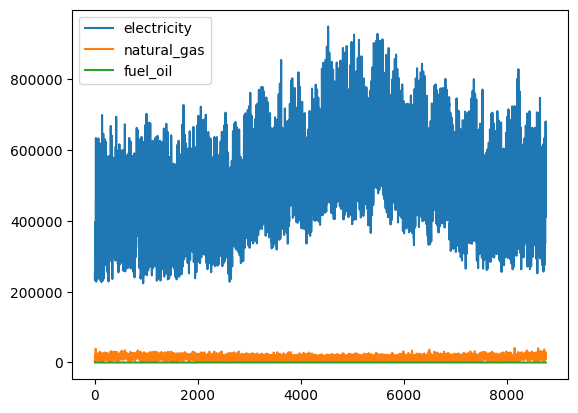

In [71]:
fuels = FuelSummationTransformer().end_uses
fuel_sums = {
    fuel: df[[col for col in df.columns if fuel in col]].sum(axis=1)
    for fuel in fuels
}
pd.DataFrame(fuel_sums).plot()

In [41]:
!pip install requests

  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached charset_normalizer-3.3.2-cp310-cp310-macosx_11_0_arm64.whl (120 kB)
